In [1]:
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

C:\Users\sanja\anaconda3\envs\tf\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    # s1 = encoder.get_layer("input_1").output           ## (512 x 512)
    s1 = encoder.get_layer("input_layer").output


    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(6, 1, padding="same", activation="softmax")(dropout)

    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model

In [3]:
K.clear_session()

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

model = build_inception_resnetv2_unet(input_shape = (512, 512, 3))
model.compile(optimizer=Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
model.summary()

Model: "InceptionResNetV2-UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 512, 512, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 255, 255, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 255, 255, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 255, 255, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 253, 253, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 253, 253, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 253, 253, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 253, 253, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 253, 253, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 253, 253, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 126, 126, 64)      │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 126, 126, 80)      │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 126, 126, 80)      │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 126, 126, 80)      │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 124, 124, 192)     │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 36,793,414 (140.36 MB)

 Trainable params: 36,752,390 (140.20 MB)

 Non-trainable params: 41,024 (160.25 KB)

In [4]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = 'InceptionResNetV2-UNet.h5',
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = 12, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "model_training.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [5]:
model.load_weights("./InceptionResNetV2-UNet.h5")

## GAN

In [6]:
IMAGE_SIZE = (512, 512)
NUM_CLASSES = 6

def load_image_mask_pair(img_path, mask_path):
    # Read image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize

    # Read mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1)
    mask = tf.image.resize(mask, IMAGE_SIZE, method='nearest')
    mask = tf.cast(mask, tf.uint8)

    return img, mask

def one_hot_encode_mask(mask):
    # Convert shape (H, W, 1) → (H, W, NUM_CLASSES)
    mask = tf.squeeze(mask, axis=-1)
    mask = tf.one_hot(mask, NUM_CLASSES)
    return mask

def generate_paths(images_dir, masks_dir):
    image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    return image_files, mask_files

def build_gan_dataset(image_paths, mask_paths, unet_model, batch_size=8, shuffle=True):
    def _generator():
        for img_path, mask_path in zip(image_paths, mask_paths):
            img, mask = load_image_mask_pair(img_path, mask_path)
            onehot_mask = one_hot_encode_mask(mask)
            pred_mask = unet_model.predict(tf.expand_dims(img, axis=0))[0]  # shape: (512, 512, 6)
            yield img, pred_mask, onehot_mask

    output_signature = (
        tf.TensorSpec(shape=(512, 512, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(512, 512, NUM_CLASSES), dtype=tf.float32),
        tf.TensorSpec(shape=(512, 512, NUM_CLASSES), dtype=tf.float32),
    )

    dataset = tf.data.Dataset.from_generator(_generator, output_signature=output_signature)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [11]:
# Paths
train_img_dir = 'Semantic segmentation dataset/final_train_images/images/'
train_mask_dir = 'Semantic segmentation dataset/final_train_masks/masks/'

val_img_dir = 'Semantic segmentation dataset/final_val_images/images/'
val_mask_dir = 'Semantic segmentation dataset/final_val_masks/masks/'

# Generate file lists
train_image_paths, train_mask_paths = generate_paths(train_img_dir, train_mask_dir)
val_image_paths, val_mask_paths = generate_paths(val_img_dir, val_mask_dir)

In [13]:
# train_image_paths

In [14]:
# Build GAN datasets
train_gan_dataset = build_gan_dataset(train_image_paths, train_mask_paths, model)

In [16]:
val_gan_dataset = build_gan_dataset(val_image_paths, val_mask_paths, model, shuffle=False)

In [17]:
for real_img, pred_mask, true_mask in train_gan_dataset:
    print(real_img.shape)     # (B, 512, 512, 3)
    print(pred_mask.shape)    # (B, 512, 512, 6)
    print(true_mask.shape)    # (B, 512, 512, 6)
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [19]:
for real_img, pred_mask, true_mask in val_gan_dataset:
    print(real_img.shape)     # (B, 512, 512, 3)
    print(pred_mask.shape)    # (B, 512, 512, 6)
    print(true_mask.shape)    # (B, 512, 512, 6)
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
(8, 512, 512, 3)
(8, 512, 512, 6)
(8, 512, 512, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model

def build_generator(input_shape_mask=(512,512,6), input_shape_img=(512,512,3)):
    # Inputs: predicted mask and original image
    mask_input = Input(shape=input_shape_mask, name='pred_mask')
    img_input  = Input(shape=input_shape_img, name='orig_image')
    x = Concatenate(axis=-1)([mask_input, img_input])  # shape (512,512,9)
    
    # Downsampling path
    d1 = Conv2D(64, kernel_size=4, strides=2, padding='same')(x)
    d1 = LeakyReLU(alpha=0.2)(d1)  # shape (256,256,64)

    d2 = Conv2D(128, 4, strides=2, padding='same')(d1)
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU(alpha=0.2)(d2)  # (128,128,128)

    d3 = Conv2D(256, 4, strides=2, padding='same')(d2)
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)  # (64,64,256)

    d4 = Conv2D(512, 4, strides=2, padding='same')(d3)
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU(alpha=0.2)(d4)  # (32,32,512)

    d5 = Conv2D(512, 4, strides=2, padding='same')(d4)
    d5 = BatchNormalization()(d5)
    d5 = LeakyReLU(alpha=0.2)(d5)  # (16,16,512) - bottleneck

    # Upsampling path (with skip connections)
    u1 = Conv2DTranspose(512, 4, strides=2, padding='same')(d5)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u1 = Concatenate(axis=-1)([u1, d4])  # (32,32,1024)

    u2 = Conv2DTranspose(256, 4, strides=2, padding='same')(u1)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    u2 = Concatenate(axis=-1)([u2, d3])  # (64,64,512)

    u3 = Conv2DTranspose(128, 4, strides=2, padding='same')(u2)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = Concatenate(axis=-1)([u3, d2])  # (128,128,256)

    u4 = Conv2DTranspose(64, 4, strides=2, padding='same')(u3)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)
    u4 = Concatenate(axis=-1)([u4, d1])  # (256,256,128)

    u5 = Conv2DTranspose(64, 4, strides=2, padding='same')(u4)
    u5 = BatchNormalization()(u5)
    u5 = Activation('relu')(u5)         # (512,512,64)

    # Final output layer: 6 classes with softmax
    output_mask = Conv2D(6, kernel_size=1, activation='softmax')(u5)  # (512,512,6)
    
    return Model(inputs=[mask_input, img_input], outputs=output_mask, name='Generator')

# Instantiate the generator
generator = build_generator()
generator.summary()

C:\Users\sanja\anaconda3\envs\tf\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pred_mask (InputLayer)        │ (None, 512, 512, 6)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ orig_image (InputLayer)       │ (None, 512, 512, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_4 (Concatenate)   │ (None, 512, 512, 9)       │               0 │ pred_mask[0][0],           │
│                               │                           │                 │ orig_image[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_212 (Conv2D)           │ (None, 256, 256, 64)      │           9,280 │ concatenate_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 256, 256, 64)      │               0 │ conv2d_212[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_213 (Conv2D)           │ (None, 128, 128, 128)     │         131,200 │ leaky_re_lu[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_211       │ (None, 128, 128, 128)     │             512 │ conv2d_213[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 128, 128, 128)     │               0 │ batch_normalization_211[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_214 (Conv2D)           │ (None, 64, 64, 256)       │         524,544 │ leaky_re_lu_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_212       │ (None, 64, 64, 256)       │           1,024 │ conv2d_214[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)     │ (None, 64, 64, 256)       │               0 │ batch_normalization_212[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_215 (Conv2D)           │ (None, 32, 32, 512)       │       2,097,664 │ leaky_re_lu_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_213       │ (None, 32, 32, 512)       │           2,048 │ conv2d_215[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU)     │ (None, 32, 32, 512)       │               0 │ batch_normalization_213[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_216 (Conv2D)           │ (None, 16, 16, 512)       │       4,194,816 │ leaky_re_lu_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 16,799,046 (64.08 MB)

 Trainable params: 16,794,182 (64.06 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [21]:
def build_discriminator(input_shape_mask=(512,512,6), input_shape_img=(512,512,3)):
    mask_input = Input(shape=input_shape_mask, name='seg_mask')
    img_input  = Input(shape=input_shape_img, name='orig_image')
    x = Concatenate(axis=-1)([img_input, mask_input])  # (512,512,9)
    
    # Downscaling conv layers
    d1 = Conv2D(64, 4, strides=2, padding='same')(x)
    d1 = LeakyReLU(alpha=0.2)(d1)  # (256,256,64)
    
    d2 = Conv2D(128, 4, strides=2, padding='same')(d1)
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU(alpha=0.2)(d2)  # (128,128,128)
    
    d3 = Conv2D(256, 4, strides=2, padding='same')(d2)
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)  # (64,64,256)
    
    d4 = Conv2D(512, 4, strides=1, padding='same')(d3)
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU(alpha=0.2)(d4)  # (64,64,512)
    
    # Final output: 1-channel patch output
    patch_out = Conv2D(1, 4, strides=1, padding='same')(d4)  # (64,64,1) patch logits
    return Model(inputs=[mask_input, img_input], outputs=patch_out, name='Discriminator')

# Instantiate the discriminator
discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ orig_image (InputLayer)       │ (None, 512, 512, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ seg_mask (InputLayer)         │ (None, 512, 512, 6)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_9 (Concatenate)   │ (None, 512, 512, 9)       │               0 │ orig_image[0][0],          │
│                               │                           │                 │ seg_mask[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_218 (Conv2D)           │ (None, 256, 256, 64)      │           9,280 │ concatenate_9[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU)     │ (None, 256, 256, 64)      │               0 │ conv2d_218[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_219 (Conv2D)           │ (None, 128, 128, 128)     │         131,200 │ leaky_re_lu_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_220       │ (None, 128, 128, 128)     │             512 │ conv2d_219[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU)     │ (None, 128, 128, 128)     │               0 │ batch_normalization_220[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_220 (Conv2D)           │ (None, 64, 64, 256)       │         524,544 │ leaky_re_lu_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_221       │ (None, 64, 64, 256)       │           1,024 │ conv2d_220[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU)     │ (None, 64, 64, 256)       │               0 │ batch_normalization_221[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_221 (Conv2D)           │ (None, 64, 64, 512)       │       2,097,664 │ leaky_re_lu_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_222       │ (None, 64, 64, 512)       │           2,048 │ conv2d_221[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU)     │ (None, 64, 64, 512)       │               0 │ batch_normalization_222[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_222 (Conv2D)           │ (None, 64, 64, 1)         │           8,193 │ leaky_re_lu_8[0][0]        │
└───────────────────────────────┴───────────────────────────┴───────────────

 Total params: 2,774,465 (10.58 MB)

 Trainable params: 2,772,673 (10.58 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [22]:
import tensorflow as tf

# Loss functions and optimizers
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
ce_loss  = tf.keras.losses.CategoricalCrossentropy()  # segmentation loss
lambda_seg = 10.0  # weight for segmentation loss
g_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# Example training loop
num_epochs = 2
for epoch in range(num_epochs):
    for (real_img, pred_mask, true_mask) in train_gan_dataset:  # ground-truth image, predicted mask, true mask
        # -------------------------
        # Update Discriminator
        # -------------------------
        with tf.GradientTape() as d_tape:
            # Generate fake mask
            fake_mask = generator([pred_mask, real_img], training=True)
            
            # Discriminator outputs for real and fake
            real_output = discriminator([true_mask, real_img], training=True)
            fake_output = discriminator([fake_mask, real_img], training=True)
            
            # Discriminator loss: real->1, fake->0
            d_loss_real = bce_loss(tf.ones_like(real_output), real_output)
            d_loss_fake = bce_loss(tf.zeros_like(fake_output), fake_output)
            d_loss = (d_loss_real + d_loss_fake) * 0.5
        
        # Compute and apply gradients to D
        d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
        d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))
        
        # -------------------------
        # Update Generator
        # -------------------------
        with tf.GradientTape() as g_tape:
            fake_mask = generator([pred_mask, real_img], training=True)
            fake_output = discriminator([fake_mask, real_img], training=False)
            
            # Generator adversarial loss (wants D(fake) ~ 1)
            adv_loss = bce_loss(tf.ones_like(fake_output), fake_output)
            # Segmentation loss: compare fake_mask with true_mask
            seg_loss = ce_loss(true_mask, fake_mask)  # or tf.keras.losses.Dice()
            
            # Total generator loss
            g_loss = adv_loss + lambda_seg * seg_loss
        
        # Compute and apply gradients to G
        g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
        g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))
        
        # (Optional) log losses, etc.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

AbortedError: {{function_node __wrapped____MklNativeConv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:CPU:0}} Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_grad_input_ops.cc:546 [Op:Conv2DBackpropInput] name: 

## GAN V2

In [6]:
# !pip install segmentation-models tensorflow-addons

In [9]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
from tensorflow.keras import layers, Model
import segmentation_models as sm

# Required for correct model loading
sm.framework()

Segmentation Models: using `tf.keras` framework.


'tf.keras'

In [10]:
def build_base_unet(input_shape=(512,512,3), n_classes=6):
    """
    Uses segmentation_models Unet with InceptionResNetV2 encoder.
    Automatically handles skip shapes.
    """
    sm.set_framework('tf.keras')
    sm.framework()
    base_model = sm.Unet(
        'inceptionresnetv2',
        input_shape=input_shape,
        encoder_weights='imagenet',
        classes=n_classes,
        activation='softmax',
    )
    return base_model

seg_model = build_base_unet()
seg_model.summary()  # you’ll see perfectly matched skip shapes

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 512, 512, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_407 (Conv2D)           │ (None, 256, 256, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_406       │ (None, 256, 256, 32)      │              96 │ conv2d_407[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_406 (Activation)   │ (None, 256, 256, 32)      │               0 │ batch_normalization_406[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_408 (Conv2D)           │ (None, 256, 256, 32)      │           9,216 │ activation_406[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_407       │ (None, 256, 256, 32)      │              96 │ conv2d_408[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_407 (Activation)   │ (None, 256, 256, 32)      │               0 │ batch_normalization_407[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_409 (Conv2D)           │ (None, 256, 256, 64)      │          18,432 │ activation_407[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_408       │ (None, 256, 256, 64)      │             192 │ conv2d_409[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_408 (Activation)   │ (None, 256, 256, 64)      │               0 │ batch_normalization_408[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_8               │ (None, 128, 128, 64)      │               0 │ activation_408[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_410 (Conv2D)           │ (None, 128, 128, 80)      │           5,120 │ max_pooling2d_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_409       │ (None, 128, 128, 80)      │             240 │ conv2d_410[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_409 (Activation)   │ (None, 128, 128, 80)      │               0 │ batch_normalization_409[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_411 (Conv2D)           │ (None, 128, 128, 192)     │         138,24

 Total params: 62,062,278 (236.75 MB)

 Trainable params: 61,999,750 (236.51 MB)

 Non-trainable params: 62,528 (244.25 KB)

In [11]:
def build_refiner(input_shape=(512,512,6), n_classes=6):
    inp = layers.Input(shape=input_shape, name='refiner_in')
    # Light downsample
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inp)  # 512→256
    x = layers.LeakyReLU(0.2)(x)
    # Bottleneck
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)  # 256→128
    x = layers.LeakyReLU(0.2)(x)
    # Upsample + skip from first block
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)  # 128→256
    x = layers.LeakyReLU(0.2)(x)
    # Skip connection
    skip = inp[:, ::2, ::2, :]  # simple 2×2 strided slice of input as skip
    x = layers.Concatenate()([x, skip])
    # Final upsample to original size
    x = layers.Conv2DTranspose(n_classes, 4, strides=2, padding='same')(x)  # 256→512
    out = layers.Activation('softmax', name='refined_mask')(x)
    return Model(inp, out, name='RefinementGenerator')

generator = build_refiner()
generator.summary()

Model: "RefinementGenerator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ refiner_in (InputLayer)       │ (None, 512, 512, 6)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_610 (Conv2D)           │ (None, 256, 256, 64)      │           6,208 │ refiner_in[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 256, 256, 64)      │               0 │ conv2d_610[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_611 (Conv2D)           │ (None, 128, 128, 128)     │         131,200 │ leaky_re_lu[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 128, 128, 128)     │               0 │ conv2d_611[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_1            │ (None, 256, 256, 64)      │         131,136 │ leaky_re_lu_1[0][0]        │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)     │ (None, 256, 256, 64)      │               0 │ conv2d_transpose_1[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 256, 256, 6)       │               0 │ refiner_in[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 256, 256, 70)      │               0 │ leaky_re_lu_2[0][0],       │
│                               │                           │                 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_2            │ (None, 512, 512, 6)       │           6,726 │ concatenate_2[0][0]        │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ refined_mask (Activation)     │ (None, 512, 512, 6)       │               0 │ conv2d_transpose_2[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 275,270 (1.05 MB)

 Trainable params: 275,270 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def build_discriminator(input_shape=(512,512,6)):
    inp = layers.Input(shape=input_shape, name='disc_in')
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inp)  # 512→256
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)   # 256→128
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)   # 128→64
    x = layers.LeakyReLU(0.2)(x)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(1, activation='sigmoid', name='disc_out')(x)
    return Model(inp, out, name='Discriminator')

discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ disc_in (InputLayer)                 │ (None, 512, 512, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_612 (Conv2D)                  │ (None, 256, 256, 64)        │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_613 (Conv2D)                  │ (None, 128, 128, 128)       │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_614 (Conv2D)                  │ (None, 64, 64, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ disc_out (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 662,209 (2.53 MB)

 Trainable params: 662,209 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
import tensorflow as tf
import os

IMAGE_SIZE = 512
NUM_CLASSES = 6
BATCH_SIZE = 8
CLASS_RGB_VALUES  = tf.constant([
        [60, 16, 152],
        [132, 41, 246],
        [110, 193, 228],
        [254, 221, 58],
        [226, 169, 41],
        [155, 155, 155]  # Class 5
    ], dtype=tf.uint8)
def parse_image(img_path: str, mask_path: str):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)  # Assume RGB mask
    mask = tf.image.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), method='nearest')

    # Convert RGB to one-hot class (this is project-specific logic)
    mask = rgb_to_onehot(mask)

    return image, mask
    
def rgb_to_onehot(mask):
    """
    Converts an RGB image mask to a one-hot encoded mask using TensorFlow ops.
    Input: [H, W, 3] uint8
    Output: [H, W, num_classes] float32
    """
    mask = tf.cast(mask, tf.uint8)  # Make sure the mask is uint8
    equality = tf.equal(tf.expand_dims(mask, axis=-2), CLASS_RGB_VALUES)
    class_map = tf.reduce_all(equality, axis=-1)  # shape: [H, W, num_classes]
    one_hot_mask = tf.cast(class_map, tf.float32)
    return one_hot_mask

def load_dataset(image_dir, mask_dir):
    image_paths = sorted([os.path.join(image_dir, x) for x in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, x) for x in os.listdir(mask_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

In [30]:
final_train_images_dir = 'Semantic segmentation dataset/final_train_images/images/'
final_train_masks_dir  = 'Semantic segmentation dataset/final_train_masks/masks/'
final_val_images_dir  = 'Semantic segmentation dataset/final_val_images/images/'
final_val_masks_dir   = 'Semantic segmentation dataset/final_val_masks/masks/'

In [27]:
# final_train_images_dir = 'Semantic segmentation dataset/final_train_images/'
# final_train_masks_dir  = 'Semantic segmentation dataset/final_train_masks/'
# final_val_images_dir  = 'Semantic segmentation dataset/final_val_images/'
# final_val_masks_dir   = 'Semantic segmentation dataset/final_val_masks/'

In [31]:
# Set paths
train_dataset = load_dataset(final_train_images_dir, final_train_masks_dir)
val_dataset = load_dataset(final_val_images_dir,final_val_masks_dir)

In [33]:
# Losses & optimizers
cce  = tf.keras.losses.CategoricalCrossentropy()
bce  = tf.keras.losses.BinaryCrossentropy()
optG = tf.keras.optimizers.Adam(1e-4)
optD = tf.keras.optimizers.Adam(1e-4)
lambda_adv = 0.1
epochs = 2
@tf.function
def train_step(images, true_masks):
    # 1) Generator (seg_model + generator) forward & loss
    with tf.GradientTape(persistent=True) as tape:
        coarse = seg_model(images, training=True)                # 512×512×6
        refined = generator(coarse, training=True)               # 512×512×6

        # Discriminator preds
        d_real = discriminator(true_masks, training=True)
        d_fake = discriminator(refined,   training=True)

        # Losses
        seg_loss = cce(true_masks, refined)
        adv_loss = bce(tf.ones_like(d_fake), d_fake)
        g_loss   = seg_loss + lambda_adv * adv_loss

        d_loss   = 0.5 * (
            bce(tf.ones_like(d_real), d_real) +
            bce(tf.zeros_like(d_fake), d_fake)
        )

    # 2) Backprop
    gradsG = tape.gradient(g_loss, seg_model.trainable_variables + generator.trainable_variables)
    opts = list(zip(gradsG, seg_model.trainable_variables + generator.trainable_variables))
    optG.apply_gradients(opts)

    gradsD = tape.gradient(d_loss, discriminator.trainable_variables)
    optD.apply_gradients(zip(gradsD, discriminator.trainable_variables))
    return seg_loss, adv_loss, d_loss

# Training loop
for epoch in range(1, epochs+1):
    for imgs, masks in train_dataset:
        seg_l, adv_l, d_l = train_step(imgs, masks)
    print(f"Epoch {epoch} → seg:{seg_l:.4f} adv:{adv_l:.4f} disc:{d_l:.4f}")

Epoch 1 → seg:1.4633 adv:3.0190 disc:0.0954
Epoch 2 → seg:0.9425 adv:5.4437 disc:0.0120


In [ ]:
ckpt = tf.train.Checkpoint(seg_model=seg_model,
                           generator=generator,
                           discriminator=discriminator,
                           optG=optG,
                           optD=optD)

ckpt_manager = tf.train.CheckpointManager(ckpt, './checkpoints', max_to_keep=3)

# ==== Restore if available ====
start_epoch = 1
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint restored from:", ckpt_manager.latest_checkpoint)
    # Optional: Restore epoch number if you save it externally
else:
    print("No checkpoint found. Starting from scratch.")

# ==== Training Step ====
@tf.function
def train_step(images, true_masks):
    with tf.GradientTape(persistent=True) as tape:
        coarse = seg_model(images, training=True)
        refined = generator(coarse, training=True)

        # Discriminator outputs
        d_real = discriminator(true_masks, training=True)
        d_fake = discriminator(refined, training=True)

        # Losses
        seg_loss = cce(true_masks, refined)
        adv_loss = bce(tf.ones_like(d_fake), d_fake)
        g_loss = seg_loss + lambda_adv * adv_loss

        d_loss = 0.5 * (
            bce(tf.ones_like(d_real), d_real) +
            bce(tf.zeros_like(d_fake), d_fake)
        )

    # Backpropagation
    gradsG = tape.gradient(g_loss, seg_model.trainable_variables + generator.trainable_variables)
    optG.apply_gradients(zip(gradsG, seg_model.trainable_variables + generator.trainable_variables))

    gradsD = tape.gradient(d_loss, discriminator.trainable_variables)
    optD.apply_gradients(zip(gradsD, discriminator.trainable_variables))

    return seg_loss, adv_loss, d_loss

# ==== Training Loop ====
for epoch in range(start_epoch, epochs + 1):
    for imgs, masks in train_dataset:
        seg_l, adv_l, d_l = train_step(imgs, masks)

    print(f"Epoch {epoch} → seg:{seg_l:.4f} adv:{adv_l:.4f} disc:{d_l:.4f}")

    # Save checkpoint after every epoch
    ckpt_manager.save()

Coarse Segmentation Mask:


TypeError: Invalid shape (512, 512, 6) for image data

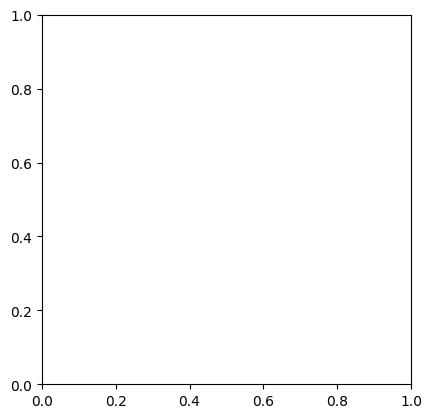

In [34]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def predict_and_refine(image_path, seg_model, generator):
    # Step 1: Load and preprocess the image
    image = Image.open(image_path)
    image = image.resize((512, 512))  # Resize to match model input size
    image_array = np.array(image) / 255.0  # Normalize to [0, 1]
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Step 2: Predict coarse segmentation mask (from seg_model)
    coarse = seg_model(image_array, training=False)
    print("Coarse Segmentation Mask:")
    plt.imshow(coarse[0])  # Show the first mask from the batch
    plt.title("Coarse Segmentation Mask")
    plt.show()

    # Step 3: Refine the coarse mask with the generator
    refined = generator(coarse, training=False)
    print("Refined Segmentation Mask:")
    plt.imshow(refined[0])  # Show the refined mask
    plt.title("Refined Segmentation Mask")
    plt.show()

    # Step 4: Display the original input image
    print("Original Input Image:")
    plt.imshow(image)  # Show the original input image
    plt.title("Original Input Image")
    plt.show()

    # Return the intermediate outputs for further use if needed
    return coarse[0], refined[0]

# Example usage:
image_path = r"C:\Users\sanja\Sem-6\Applied AI\PROJECT\Semantic segmentation dataset\final_val_images\images\aug_4_image_t2_001.jpg"
coarse_mask, refined_mask = predict_and_refine(image_path, seg_model, generator)


Coarse Segmentation Mask (RGB):


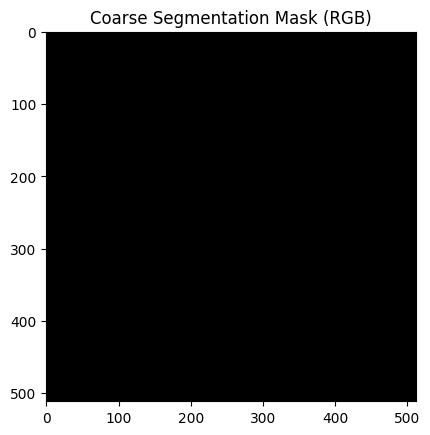

In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def one_hot_to_rgb(one_hot_mask, color_map=None):
    """
    Converts a one-hot encoded mask (with 6 channels) to an RGB image.
    
    Args:
        one_hot_mask: A tensor of shape (H, W, 6) where each pixel is one-hot encoded.
        color_map: A dictionary that maps class indices to RGB values (optional).
    
    Returns:
        rgb_image: A numpy array of shape (H, W, 3) representing the RGB image.
    """
    # Default color map (you can change these colors for each class)
    if color_map is None:
        color_map = {
           0 : [60, 16, 152],
            1 : [132, 41, 246],
            2 : [110, 193, 228],
            3 : [254, 221, 58],
            4 : [226, 169, 41],
            5 : [155, 155, 155]  
        }

    # Initialize an empty RGB image
    height, width, _ = one_hot_mask.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

    # For each class, we get the one-hot mask and assign the corresponding RGB color
    for class_index in range(6):
        mask_class = one_hot_mask[:, :, class_index]  # (H, W)
        rgb_image[mask_class == 1] = color_map[class_index]

    return rgb_image

def predict_and_refine_with_rgb(image_path, seg_model, generator):
    # Step 1: Load and preprocess the image
    image = Image.open(image_path)
    image = image.resize((512, 512))  # Resize to match model input size
    image_array = np.array(image) / 255.0  # Normalize to [0, 1]
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Step 2: Predict coarse segmentation mask (from seg_model)
    coarse = seg_model(image_array, training=False)
    # print("Coarse Segmentation Mask:")
    # plt.imshow(coarse[0])  # Show the first mask from the batch
    # plt.title("Coarse Segmentation Mask (6 Channels)")
    # plt.show()

    # Step 3: Refine the coarse mask with the generator
    refined = generator(coarse, training=False)
    # print("Refined Segmentation Mask:")
    # plt.imshow(refined[0])  # Show the refined mask
    # plt.title("Refined Segmentation Mask (6 Channels)")
    # plt.show()

    # Step 4: Decode the coarse and refined masks into RGB images
    coarse_rgb = one_hot_to_rgb(coarse[0])  # Convert to RGB
    refined_rgb = one_hot_to_rgb(refined[0])  # Convert to RGB

    # # Step 5: Display the RGB masks
    print("Coarse Segmentation Mask (RGB):")
    plt.imshow(coarse_rgb)  # Show RGB coarse mask
    plt.title("Coarse Segmentation Mask (RGB)")
    plt.show()

    # print("Refined Segmentation Mask (RGB):")
    # plt.imshow(refined_rgb)  # Show RGB refined mask
    # plt.title("Refined Segmentation Mask (RGB)")
    # plt.show()

    # # Step 6: Display the original input image
    # print("Original Input Image:")
    # plt.imshow(image)  # Show the original input image
    # plt.title("Original Input Image")
    # plt.show()

    return coarse_rgb, refined_rgb

# Example usage:
image_path = r"C:\Users\sanja\Sem-6\Applied AI\PROJECT\Semantic segmentation dataset\final_val_images\images\aug_4_image_t2_001.jpg"
coarse_rgb, refined_rgb = predict_and_refine_with_rgb(image_path, seg_model, generator)


In [44]:
coarse_rgb.shape

(512, 512, 3)